# Data Insight Assessment 

## Sobre o desafio 
De acordo com que foi passado no desafio no Github.

*O desafio envolve analisar campanhas de marketing de uma institiução bancária. Nas campanhas é vendido ao cliente um produto adicional de débito automático. Queremos saber se um determinado cliente se inscreve ou não ao produto. *

## Estratégia de análise
Para a análise, dividirei em duas partes, uma parte descritiva da base, buscando entender qual é a taxa de resposta (inscrição ao produto) dentro das variáveis qualitativas e se existe diferenças significativas nelas; e a parte de desenvolvimento do modelo de propensão a se inscrever no produto. Usarei, nessa modelagem de propensão, modelos clássicos (regressão logística, árvores de decisão, floresta de decisão) e irei avaliar a qualidade dos ajustes usando métricas de avaliação baseadas na matriz de confusão e curva ROC.



Primeiramente, iremos carregar as bibliotecas necessárias para o desenvolvimento das análises

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, mean_squared_error


Vamos carregar a base e olhar as cinco primeiras linhas.

In [2]:
campanhas = pd.read_csv("data/campaigns.csv", index_col = 0)

campanhas.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Vamos checar se os tipos de dados casam com a informação necessária.

In [3]:
campanhas.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Antes de mais nada, vamos verificar qual é o percentual de clientes que se inscreveram no produto.

In [4]:
100 * campanhas.groupby('y').y.count()/campanhas['y'].count()

y
no     88.235439
yes    11.764561
Name: y, dtype: float64

Cerca de 11,8% dos clientes aderiram ao produto.

Podemos usar esse percentual como base para as análises descritivas.

## Análise descritiva

Iniciaremos nossa análise descritiva estudando as variáveis quantitativas e sua relação com a variável resposta, e propor uma categorização dessas variáveis de tal maneira que, ao ajustar os modelos, trabalhemos com variáveis dummies ao invés do número.

Primeiramente, iremos definir uma função que toma os dados da campanha, uma coluna com as variáveis qualitativas, e retorna um gráfico de barras com o percentual de inscrição e uma tabela descritiva dos dados.

In [5]:
def plotar_taxa_resposta(campanhas, coluna):
    ### função plotar_taxa_resposta
    ### argumentos:
    ###  campanhas: data frame com os dados da campanha
    ###  coluna: nome da coluna que desejamos plotar o gráfico
    ### saída:
    ###  objeto w com o plot do gráfico de barras com o percentual de 
    ###   taxa de adesão e a tabela com os dados
    ###
    ### função para desenhar um gráfico de barras de cada coluna qualitativa
    ###  que representa o % da taxa de adesão
    tabdinamica = pd.crosstab(campanhas[coluna],campanhas['y'])
    tabdinamica = tabdinamica.reset_index()
    tabdinamica.index = tabdinamica[coluna].values
    tabdinamica = tabdinamica.drop(coluna, axis=1)
    tabdinamica['y_rate'] = 100*tabdinamica['yes']/(tabdinamica['no']+tabdinamica['yes'])
    tabdinamica['n_rate'] = 100-tabdinamica['y_rate'] 
    w = tabdinamica['y_rate'].plot.bar()
    for p in w.patches:
        w.annotate(str(np.round(p.get_height(),1))+"%", (p.get_x(), p.get_height()))

    plt.ylabel('%')
    
    return w, tabdinamica

Iremos, adicionalmente, criar uma função para facilitar a análise dos dados qualitativos.

In [6]:
def plotar_percentual(campanhas, coluna):
    ### função plotar_percentual
    ### argumentos:
    ###  campanhas: data frame com os dados da campanha
    ###  coluna: nome da coluna que desejamos plotar o gráfico
    ### saída:
    ###  objeto w com o plot do gráfico de barras com o percentual de 
    ###  clientes em cada nível da coluna
    ###
    ### função para desenhar um gráfico de barras de cada coluna qualitativa
    ###  que representa o % em cada categoria
    
    # primeiro, vamos checar quais são os níveis desses fatores
    print('{}',set(campanhas[coluna]))

    # em seguida, vamos avaliar qual é a representatividade de cada fator no total da base e plotar em um gráfico
    percentage_value = 100 * campanhas[coluna].value_counts()/campanhas[coluna].count()
    dados_value = campanhas[coluna].value_counts()

    # desenhando o gráfico de barras e colocando no eixo o %
    w = percentage_value.plot.bar()

    for p in w.patches:
        w.annotate(str(np.round(p.get_height(),1))+"%", (p.get_x()-.1, p.get_height()+.15))
    
    plt.ylabel('%')
    
    return w

Vamos dar uma analisada "por cima" nas variáveis quantitativas.

In [7]:
campanhas.describe()

,age,balance,day,duration,campaign,pdays,previous
count,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000,40690.000000
mean,40.905407,1359.697518,15.808405,258.243844,2.764586,40.059867,0.579405
std,10.604908,3034.248783,8.318281,257.577068,3.110158,100.078281,2.350664
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1423.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Não temos nenhum dado missing, o que é bastante positivo pois não precisaremos fazer imputação dos dados ou sacrificar algum dado.

Desse ponto, podemos ver algumas características da base de cara:

* A idade média da base é de 40 anos, sendo que a faixa etária varia de 18 a 95 anos, nada anormal dado o negócio. Podemos afirmar que metade dos clientes estão na faixa de 33 a 48 anos.
* O balanço apresentou uma média de 1359 euros, mas com um desvio padrão de 3034 euros. Nota-se que até 25% da base possui balanço negativo e uma alta dispersão dos dados, mensurada pelo desvio padrão.
* Em média, cada contato durou 258 segundos (4.3 minutos), mas houveram pelo menos 25% das abordagens com duração entre 319 segundos e 4918 segundos. Quando analisarmos essa variável, é razoável convertê-la para minutos, para trabalhar melhor.
* Cerca de 3/4 da base de clientes foi abordada 3 vezes.
* A variável pdays e previous podem ser retrabalhadas nesse contexto, dado que -1 representa que o cliente não foi abordado.marc

Analisaremos a distribuição da **idade**, desenhando um boxplot da variável

Text(0.5, 1.0, 'Idade')

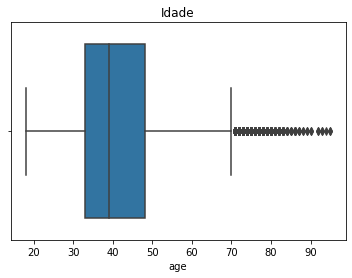

In [8]:
sns.boxplot(campanhas['age'])
plt.title("Idade")

Conforme comentamos, cerca de 50% da base estão concentrados na faixa de 33 a 48 anos. Os outliers, aqui, representam clientes idosos.

De forma análoga, iremos desenhar o boxplot da idade em função da aquisição do produto de débito automático.

Text(0.5, 1.0, 'Idade')

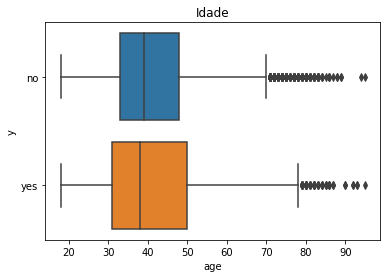

In [9]:
sns.boxplot(x=campanhas['age'],y=campanhas['y'])
plt.title("Idade")

Nota-se que a idade mediana entre quem não adquiriu e quem adquiriu não variou muito, contudo, percebe-se que a caixa do "não" é mais "compacta", indicando que a idade dos não adquirintes do produto é menor que a dos que aderiram ao produto.

Vamos categorizar a idade, considerando divisões de 10 em 10 na idade até 70 anos, e criar uma coluna com essa marcação.

In [10]:
def categorizacao_idade(x):
    ### função categorizacao_idade
    ###  entrada:
    ###   x : idade
    ###  saída:
    ###   categorização de idade
    ###  efetua a categorização da idade conforme divisão de 10 em 10
    
    if x <30:
        return("1 Até 30 anos")
    elif x >= 30 and x < 40:
        return("2 De 30 a 40 anos")
    elif x >= 40 and x < 50:
        return("3 De 40 a 50 anos")
    elif x >= 50 and x <60:
        return("4 De 50 a 60 anos")
    elif x >= 60 and x <70:
        return("5 De 60 a 70 anos")
    else: 
        return("6 Acima de 70 anos")
    
campanhas['age_categorizado'] = campanhas['age'].apply(categorizacao_idade)

Analisaremos a variável categorizada de idade, verificando a taxa de resposta de cada nível .

Text(0.5, 1.0, 'Idade')

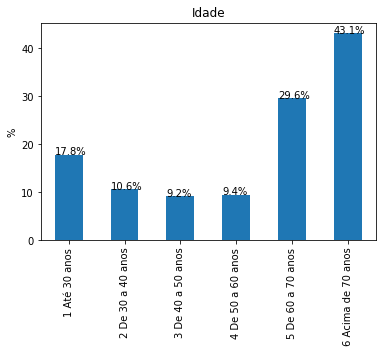

In [11]:
plotar_taxa_resposta(campanhas, 'age_categorizado')
plt.title("Idade")

Recordando o boxplot, e considerando que cerca de 50% da base está em clientes de 30 a 50 anos, é de se notar que a maior taxa de adesão se encontra entre clientes de até 30 anos e acima de 60 anos em relação a taxa de inscrição média de 11,7%.

A seguir iremos analisar o **balanço** de cada cliente. 

Recordando do que foi verificado anteriormente, vamos verficar quantos clientes tem balançopositivo ou negativo:

In [12]:
print("Clientes com saldo positivo: ",campanhas[campanhas['balance']>0].balance.count(), \
      "\nClientes com saldo negativo: ",campanhas[campanhas['balance']<0].balance.count(), \
      "\nPercentual de clientes com saldo negativo: ", round(100*campanhas[campanhas['balance']<0].balance.count()/campanhas.balance.count(),2),"%")

Clientes com saldo positivo:  34160 
Clientes com saldo negativo:  3391 
Percentual de clientes com saldo negativo:  8.33 %


Nota-se que 3.391 clientes possuem balanço negativo, o que representa 8,3% da base.

Desconsiderando os clientes de balanço negativo, vamos analisar o balanço desses clientes:

In [13]:
campanhas[campanhas['balance']>0].balance.describe()

count     34160.000000
mean       1651.177283
std        3227.812078
min           1.000000
25%         227.000000
50%         648.000000
75%        1766.000000
max      102127.000000
Name: balance, dtype: float64

Mesmo desconsiderando os clientes com balanço negativo, nota-se que existe uma alta variabilidade no saldo, mensurado pelo desvio-padrão. Vamos desenhar o boxplot e levantar qual é o valor máximo do balanço para não ser cosniderado outlier.

Máximo para não ser considerado outlier:  4074.5


Text(0.5, 1.0, 'Balanço - positivo')

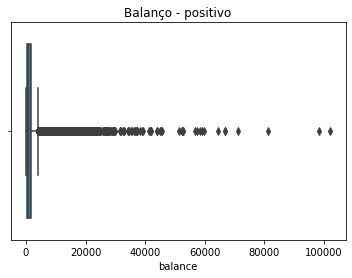

In [14]:
IIQ = campanhas[campanhas['balance']>0].balance.quantile(.75) - campanhas[campanhas['balance']>0].balance.quantile(.25)

print("Máximo para não ser considerado outlier: ", campanhas[campanhas['balance']>0].balance.quantile(.75)  + 1.5 * IIQ )

sns.boxplot(campanhas[campanhas['balance']>0].balance)
plt.title("Balanço - positivo")



Iremos segmentar de acordo com os quartis essa variável e, conforme fizemos com a idade, plotar a distribuição da taxa de adesão.

In [15]:
def balanco_quantile(x):
    ### função balanco_quantile
    ###  entrada:
    ###   x : balanço
    ###  saída:
    ###   categorização de quantil
    ###  efetua a categorização do balanço conforme quantil
    
    if x < 0:
        return("1 Saldo negativo")
    if x < 227:
        return("2 Até 227 euros")
    if x >= 227 and x <648:
        return("3 De 227 a 648 euros")
    if x >=648 and x < 1766:
        return("4 De 648 a 1766 euros")
    else:
        return("5 Acima de 1766 euros")

campanhas['balance_quantile'] = campanhas['balance'].apply(balanco_quantile)

De forma analoga a idade, vamos analisar a taxa de conversão dos clientes.

Text(0.5, 1.0, 'Balanço')

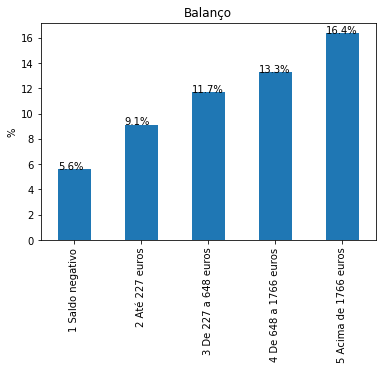

In [16]:
plotar_taxa_resposta(campanhas, 'balance_quantile')
plt.title("Balanço")

Aparentemente, temos que clientes com maior saldo apresentaram maior taxa de inscrição em relação a quem tem menos saldo ou saldo negativo. Possivelmente, ofertar um produto de débito automático para clientes com saldo negativo ou saldo baixo não seja interessante, dado que ou eles não tem fundos suficientes ou movimentam pouco a conta.

A seguir, analisaremos a **duração** da ligação.

Trabalhar com a **duração da ligação** em segundos pode ser confuso dado que, conforme auferimos anteriormente, 25% dos clientes receberam ligações de até 100 segundos. Iremos trabalhar com minutos.

Vamos converter esses dados e colocar em uma outra coluna, e analisar os dados com um descritivo e um boxplot.

In [17]:
campanhas['duration_min'] = campanhas['duration']/60

In [18]:
campanhas['duration_min'].describe()

count    40690.000000
mean         4.304064
std          4.292951
min          0.000000
25%          1.716667
50%          3.000000
75%          5.316667
max         81.966667
Name: duration_min, dtype: float64

Text(0.5, 1.0, 'Duração em minutos')

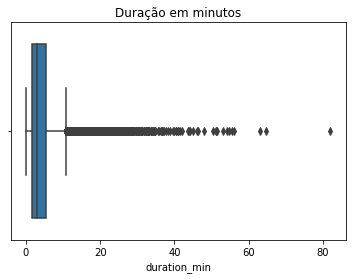

In [19]:
sns.boxplot(campanhas['duration_min'])
plt.title("Duração em minutos")

Em média, cada ligação durou 4,3 minutos, com alta variabilidade. Cerca de 50% dos clientes receberam chamados de até 3 minutos.

Novamente, temos um número considerado de outliers. Vamos calcular o máximo para não ser considerado outlier.

In [20]:
IIQ = campanhas['duration_min'].quantile(.75) - campanhas['duration_min'].quantile(.25)

print("Máximo para não ser considerado outlier: ", campanhas['duration_min'].quantile(.75)  + 1.5 * IIQ )

Máximo para não ser considerado outlier:  10.716666666666665


Ligações de até 10,7 minutos não são considerados outliers - considerando que ofertaremos um produto por contato telefônico, é um valor bastante razoável para ser considerado corte para valores discrepantes.

Vamos analisar a influência da duração do chamado na aquisição.

Text(0.5, 1.0, 'Duração em minutos')

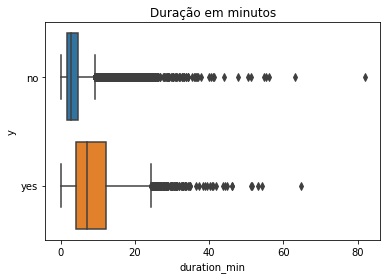

In [21]:
sns.boxplot(campanhas['duration_min'], campanhas['y'])
plt.title("Duração em minutos")

Quando analisamos a duração, nota-se que claramente a duração mediana de quem adquiriu o produto é maior que de quem não adquiriu, embora o chamado mais longo foi visto no grupo de quem não fez a aquisição. 

Vamos categorizar considerando os quartis e o corte de valor discrepante o tempo de chamado e levantar a taxa de resposta.

In [22]:
def tempo_categorizado(x):
    ### função tempo_categorizado
    ###  entrada:
    ###   x : tempo em minutos
    ###  saída:
    ###   categorização de quantil
    ###  efetua a categorização do tempo conforme quantil    
    if x < 1.7:
        return("1 Até 1:40 minutos")
    if x >= 1.7 and x < 3:
        return("2 De 1:40 a 3 minutos")
    if x >= 3 and x < 5.3:
        return("3 De 3 a 5:20 minutos")
    if x >= 5.3 and x < 10:
        return("4 De 5:20 a 10 minutos")
    else:
        return("5 Acima de 10 minutos")
    
campanhas['duration_categorizado'] = campanhas['duration_min'].apply(tempo_categorizado)

Text(0.5, 1.0, 'Duração em minutos')

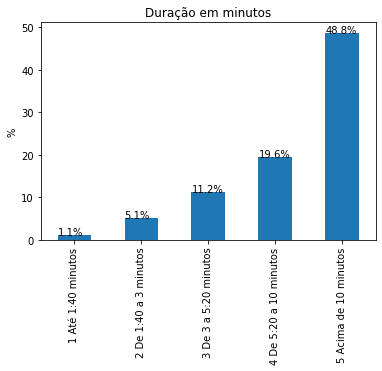

In [23]:
plotar_taxa_resposta(campanhas, 'duration_categorizado')
plt.title("Duração em minutos")

É evidente a influência da duração na taxa de adesão ao produto, pois ligações acima de 5 minutos apresentaram maior taxa de inscrição. Não obstante, devemos ler esse número com cautela, pois, conforme indicamos anteriormente, algumas ligações mais longas não geraram adesão.

Vamos analisar a quantidade de campanhas (abordagens) de cada cliente. Novamente, vamos desenhar um boxplot para entender os dados.

Text(0.5, 1.0, 'Campanhas')

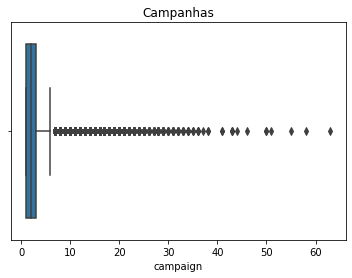

In [24]:
sns.boxplot(campanhas['campaign'] )

plt.title("Campanhas")

Novamente, temos uma quantidade considerável de outliers. Vamos verificar qual é o corte de outliers.


In [25]:
IIQ = campanhas['campaign'].quantile(.75) - campanhas['campaign'].quantile(.25)

print("Máximo para não ser considerado outlier: ", campanhas['campaign'].quantile(.75)  + 1.5 * IIQ )

Máximo para não ser considerado outlier:  6.0


Vamos, então, analisar o efeito da quantidade de campanhas com a aquisição ou não do produto em questão. 

Text(0.5, 1.0, 'Campanhas')

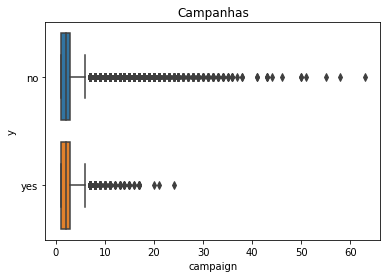

In [26]:
sns.boxplot(campanhas['campaign'], campanhas['y'])

plt.title("Campanhas")

Olhando os boxplots, não é evidente que a quantidade de campanhas tenha influência na aquisição. Contudo, verificamos que existiram clientes que não aderiram ao produto que foram abordados mais de 30 vezes - o que é uma má prática, pois pode incomodar o cliente e gerar efeito reverso.

Novamente, vamos categorizar essa variável e plotar a taxa de adesão ao produto.

In [27]:
def categoriza_campanha( x): 
    ### função categoriza_campanha
    ###  entrada:
    ###   x : campanhas
    ###  saída:
    ###   categorização da quantidade de campanhas
    ###  efetua a categorização da qtde. de campanhas se o cliente
    ###  recebeu cinco ou mais campanhas.
    if x > 5: 
        return '5+' 
    else :
        return x
    
    
campanhas['campaign_categorizado'] = campanhas['campaign'].apply(categoriza_campanha)

Text(0.5, 1.0, 'Campanhas')

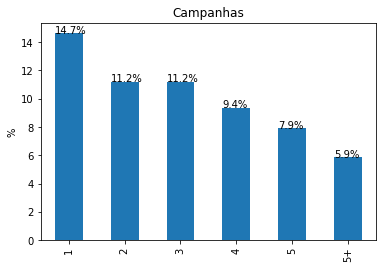

In [28]:
plotar_taxa_resposta(campanhas, 'campaign_categorizado')
plt.title("Campanhas")

Aparentemente, a taxa de adesão ao produto foi menor para clientes que foram abordados mais de cinco vezes, comparado com quem foi abordado uma vez. Novamente, isso pode ser um indício de que os clientes não gostam de ser insistentemente abordados, e que existe um limite de abordagens - clientes que foram abordados duas ou três vezes apresentaram taxa de inscrição em linha com a média.


Vamos verificar quantos clientes já foram abordados por alguma campanha

In [29]:
print("Clientes que não foram abordados anteriormente:",campanhas[campanhas['previous'] == 0].pdays.count(),\
"\nClientes abordados anteriormente: ",campanhas[campanhas['previous'] > 0].pdays.count())

Clientes que não foram abordados anteriormente: 33279 
Clientes abordados anteriormente:  7411


Ao invés de trabalhar com o valor numérico do contato anterior ou o tempo do contato anterior, vamos criar uma variável que mostra se o cliente foi abordado anteriormente e se a abordagem foi com sucesso ou não.


In [30]:
campanhas['contacted_before'] = campanhas['previous'].apply(lambda x: x>0)

campanhas['poutcome'] = campanhas['poutcome'].apply(lambda x: x=='success')

campanhas['contacted_before'] = campanhas.agg(lambda x: f"Contato {x['contacted_before']} - Resultado {x['poutcome']}", axis=1)

Conforme fizemos com as demais variáveis, vamos analisar a taxa de resposta.

Text(0.5, 1.0, 'Contato anterior')

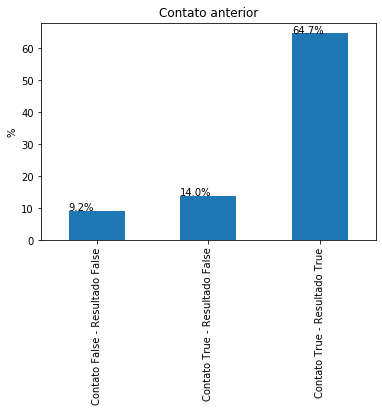

In [31]:
plotar_taxa_resposta(campanhas, 'contacted_before')
plt.title("Contato anterior")

Nota-se que a taxa de resposta de quem já foi contactado uma vez é maior que de quem não foi contactado. Mais, percebe-se que quem foi abordado com sucesso teve maior taxa de adesão de quem foi abordado sem sucesso. Isso pode indicar que uma reabordagem dos clientes que já foram abordados com sucesso pode ser uma estratégia interessante para aumentar o número de clientes inscritos no produto.

Iremos agora nos debruçar nas variáveis qualitativas. Vamos analisar a **ocupação** do cliente, verificando a distribuição da variável.

{} {'blue-collar', 'services', 'unemployed', 'management', 'unknown', 'student', 'entrepreneur', 'admin.', 'housemaid', 'technician', 'retired', 'self-employed'}


Text(0.5, 1.0, 'Ocupação')

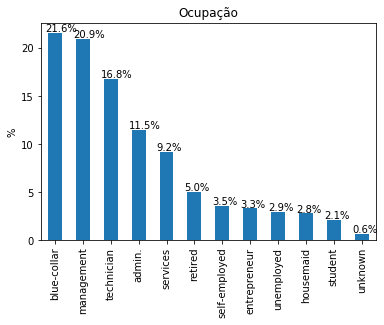

In [32]:
plotar_percentual(campanhas,'job')
plt.title("Ocupação")

Cerca da metade da base ou são profissionais "blue-collar" ou gerentes (managment). Nota-se que 0,6% da base não possuem marcação. Podemos, sem perda de generalidade, considerá-los como desempregados na hora de montar as bases.

Agora, testaremos a associação entre a ocupação e a inscrição.


Text(0.5, 1.0, 'Ocupação')

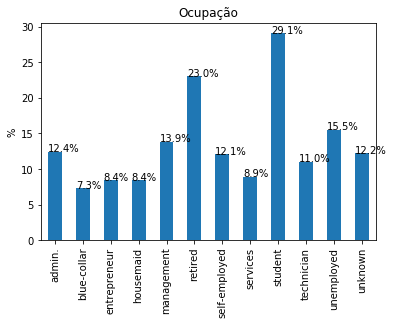

In [33]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'job')
plt.title("Ocupação")

Aparentemente, aposentados e estudantes aderiram mais ao produto do que profissionais "blue-collar", o que pode ser indício que o produto adicional de débito possa ser mais atrativo para esse público. Abaixo temos a tabela com a contagem dos clientes.

In [34]:
print(tabdinamica)

y                no   yes     y_rate     n_rate
admin.         4083   578  12.400772  87.599228
blue-collar    8132   637   7.264226  92.735774
entrepreneur   1226   113   8.439134  91.560866
housemaid      1030    95   8.444444  91.555556
management     7326  1178  13.852305  86.147695
retired        1560   467  23.038974  76.961026
self-employed  1255   172  12.053259  87.946741
services       3394   331   8.885906  91.114094
student         601   247  29.127358  70.872642
technician     6065   753  11.044295  88.955705
unemployed     1008   185  15.507125  84.492875
unknown         223    31  12.204724  87.795276


Temos evidências então que a ocupação pode ser um bom preditor para a aquisição.

Vamos analisar o **estado civil**, observando a distribuição dessa variável na base.




{} {'single', 'married', 'divorced'}


Text(0.5, 1.0, 'Estado Civil')

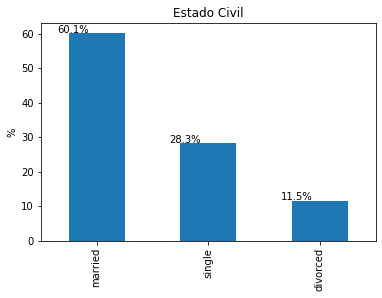

In [35]:
plotar_percentual(campanhas,'marital')
plt.title("Estado Civil")

Cerca de 60% da base de clientes é composta por clientes casados. Iremos testar se o fato do cliente estar casado ou não influencia na aquisição do produto.

Text(0.5, 1.0, 'Estado Civil')

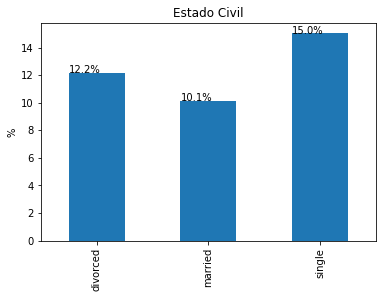

In [36]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'marital')
plt.title("Estado Civil")

Aparentemente, clientes solteiros apresentaram maior taxa de adesão ao produto do que clientes casados. Vamos levantar a tabela dinâmica.

In [37]:
print(tabdinamica)

y            no   yes     y_rate     n_rate
divorced   4124   571  12.161874  87.838126
married   21982  2482  10.145520  89.854480
single     9797  1734  15.037724  84.962276


De fato, o estado civil pode ser um bom preditor para a aquisição do produto.

De forma análoga, iremos analisar agora o **grau de instrução**.

{} {'unknown', 'secondary', 'tertiary', 'primary'}


Text(0.5, 1.0, 'Grau de Instrução')

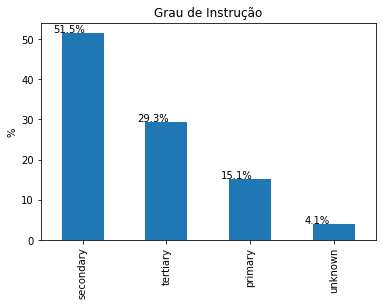

In [38]:
plotar_percentual(campanhas,'education')
plt.title("Grau de Instrução")

Cerca de metade da base de clientes é composta por clientes que finalizaram o secundário. Existe um percentual de 4% que são desconhecidos - assumindo que o cliente deixou em branco o campo porque nenhuma das opções se encaixam em sua formação, podemos usar como uma classificação de clientes sem instrução. 

Iremos testar se o grau de instrução influencia na aquisição do produto.

Text(0.5, 1.0, 'Grau de Instrução')

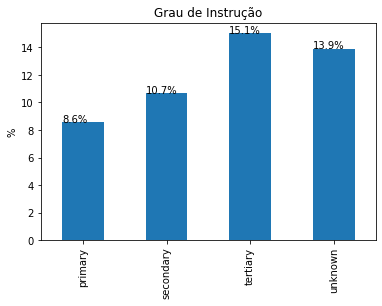

In [39]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'education')
plt.title("Grau de Instrução")

In [40]:
print(tabdinamica)

y             no   yes     y_rate     n_rate
primary     5626   527   8.564928  91.435072
secondary  18717  2234  10.662976  89.337024
tertiary   10123  1794  15.054124  84.945876
unknown     1437   232  13.900539  86.099461


Aparentemente, clientes com maior grau de instrução e, no caso, clientes sem instrução apresentaram maior taxa de adesão. 

Vamos agora analisar variáveis ligada a crédito.

Primeiramente, se o cliente tem **crédito em default**. Vamos checar qual o percentual de clientes possui crédito em default.

{} {'no', 'yes'}


Text(0.5, 1.0, 'Crédito em default')

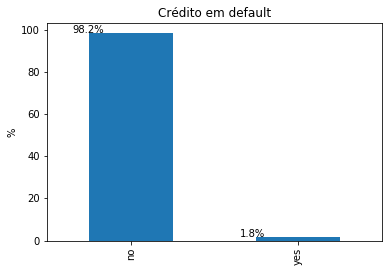

In [41]:
plotar_percentual(campanhas,'default')
plt.title("Crédito em default")

Mais de 98% da base não possuem crédito em default. 

Dado a grande quantidade de clientes sem crédito em default, não usaremos essa variável, pois ela pode explicar pouco o fato do cliente adqurir o produto ou não.

Vamos checar quantos cliente possuem **empréstimo imobiliário** e se pode ser uma melhor variável.

{} {'no', 'yes'}


Text(0.5, 1.0, 'Empréstimo Imobiliario')

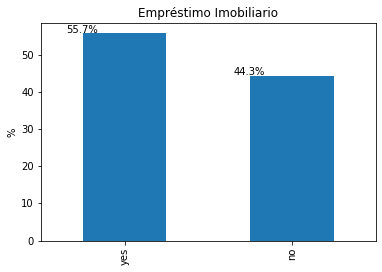

In [42]:
plotar_percentual(campanhas,'housing')
plt.title("Empréstimo Imobiliario")

Cerca de 55% da base de clientes possui algum tipo de empréstimo imobiliário. 

Iremos testar se o fato do cliente possuir empréstimo imobiliário influencia na aquisição do produto.

Text(0.5, 1.0, 'Empréstimo Imobiliario')

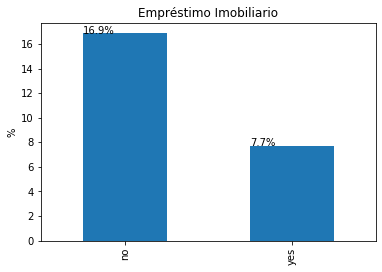

In [43]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'housing')
plt.title("Empréstimo Imobiliario")

In [44]:
print(tabdinamica)


y       no   yes     y_rate     n_rate
no   14988  3041  16.867269  83.132731
yes  20915  1746   7.704867  92.295133


Aparentemente, clientes que não possuem empréstimo imobiliário apresentaram maior taxa de adesão ao produto do que clientes que possuem, o que pode indicar que clientes que não possuem um produto financeiro de longo prazo tem maiores chances de adquirirem o produto.

Vamos, finalmente, analisar quantos clientes possuem **empréstimo pessoal**.


{} {'no', 'yes'}


Text(0.5, 1.0, 'Empréstimo pessoal')

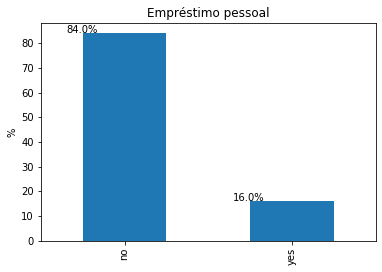

In [45]:
plotar_percentual(campanhas,'loan')
plt.title("Empréstimo pessoal")

Cerca de 84% da base de clientes não possui algum tipo de empréstimo pessoal. 

Iremos testar se o fato do cliente possuir empréstimo influencia na aquisição do produto.

Text(0.5, 1.0, 'Empréstimo Pessoal')

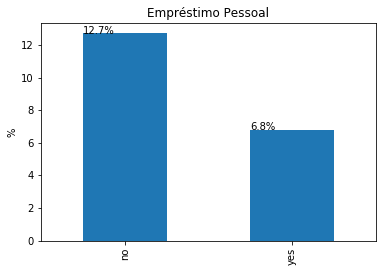

In [46]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'loan')
plt.title("Empréstimo Pessoal")


In [47]:
print(tabdinamica)


y       no   yes     y_rate     n_rate
no   29833  4344  12.710302  87.289698
yes   6070   443   6.801781  93.198219


Aparentemente, clientes sem empréstimo pessoal apresentaram maior taxa de adesão ao produto do que clientes com empréstimo.

Logo, podemos afirmar que o fato do cliente possuir empréstimo ou não, independente da natureza, é uma boa variável para predizer se o cliente vai adquirir o produto ou não.

Uma variável importante para ser avaliada é o **ponto de contato** do cliente. Iremos verificar qual é o ponto de contato predominante na base.

{} {'unknown', 'telephone', 'cellular'}


Text(0.5, 1.0, 'Contato')

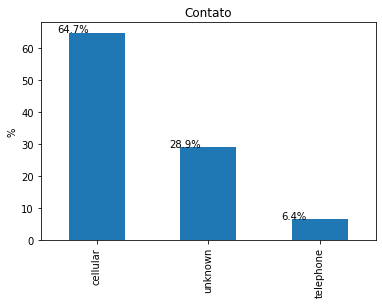

In [48]:
plotar_percentual(campanhas,'contact')
plt.title("Contato")

Cerca de 64% da base foram contactados por celular, embora 28,9% da base o ponto de contato é desconhecido - o que, para um modelo em que avaliar o ponto de contato do cliente é importante dado que precisamos operacionalizar o contato, é ruim.

Antes de prosseguir, podemos transformar essa variável em uma binária se o cliente possui ponto de contato celular ou não.

In [49]:
campanhas['contact'] = campanhas['contact'].apply(lambda x: x =='cellular')

Seguindo com a análise, iremos avaliar a taxa de adesão do produto.

Text(0.5, 1.0, 'Contato')

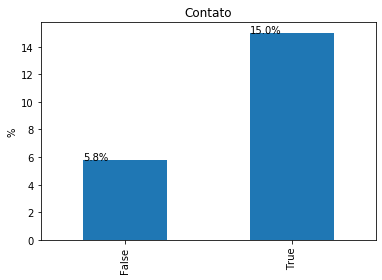

In [50]:
w, tabdinamica= plotar_taxa_resposta(campanhas, 'contact')
plt.title("Contato")


In [51]:
print(tabdinamica)


y         no   yes     y_rate     n_rate
False  13540   831   5.782479  94.217521
True   22363  3956  15.030966  84.969034


Aparentemente, clientes que foram contactado por celular apresentaram maior taxa de adesão ao produto do que clientes que foram contactados por outros meios. Quando se diz celular, o cliente pode ser abordado não apenas por telefonema, mas por SMS ou notificações push, mas no caso estamos assumindo que vai ser por meio de ligação. 

Outro ponto importante a ser avaliado é se existe algum dia ou mês que a taxa de conversão é maior. Vamos avaliar o dia.

Text(0.5, 1.0, 'Taxa de conversão dia')

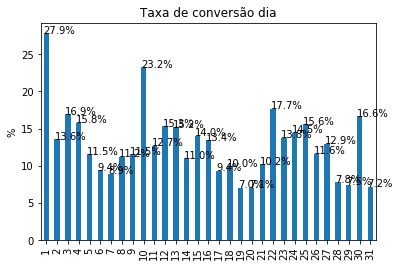

In [52]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'day')
plt.title("Taxa de conversão dia")


In [53]:
print(tabdinamica)


y     no  yes     y_rate     n_rate
1    207   80  27.874564  72.125436
2    995  156  13.553432  86.446568
3    810  165  16.923077  83.076923
4   1095  205  15.769231  84.230769
5   1529  199  11.516204  88.483796
6   1574  164   9.436133  90.563867
7   1490  146   8.924205  91.075795
8   1460  184  11.192214  88.807786
9   1251  163  11.527581  88.472419
10   360  109  23.240938  76.759062
11  1163  169  12.687688  87.312312
12  1218  220  15.299026  84.700974
13  1220  218  15.159944  84.840056
14  1465  181  10.996355  89.003645
15  1323  216  14.035088  85.964912
16  1104  171  13.411765  86.588235
17  1599  165   9.353741  90.646259
18  1882  208   9.952153  90.047847
19  1467  111   7.034221  92.965779
20  2293  174   7.053101  92.946899
21  1634  186  10.219780  89.780220
22   665  143  17.698020  82.301980
23   731  117  13.797170  86.202830
24   349   59  14.460784  85.539216
25   645  119  15.575916  84.424084
26   822  108  11.612903  88.387097
27   874  130  12.948207  87

Notamos dois picos significativos: no dia 1 e no dia 10. Se formos analisar o fato de que clientes recebem o salário ou aposentadoria no dia 1 ou no dia 30, pode ser interessante fazer uma abordagem mais concentrada perto do dia do pagamento.

Vamos analisar o mês.

Text(0.5, 1.0, 'Mês')

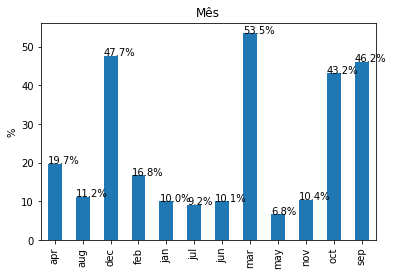

In [54]:
w, tabdinamica = plotar_taxa_resposta(campanhas, 'month')
plt.title("Mês")

In [55]:
print(tabdinamica)


y       no  yes     y_rate     n_rate
apr   2124  522  19.727891  80.272109
aug   4977  629  11.220121  88.779879
dec    101   92  47.668394  52.331606
feb   1966  397  16.800677  83.199323
jan   1141  127  10.015773  89.984227
jul   5641  573   9.221114  90.778886
jun   4358  490  10.107261  89.892739
mar    197  227  53.537736  46.462264
may  11575  838   6.750987  93.249013
nov   3168  367  10.381895  89.618105
oct    375  285  43.181818  56.818182
sep    280  240  46.153846  53.846154


Temos destacadamente quatro picos: março, setembro, outubro e dezembro.


## Treinando o modelo

Para treinarmos os modelos, iremos criar uma segunda tabela, desconsiderando as colunas que não iremos utilizar.

In [56]:
campanhas_treinomodelo = campanhas.drop(["default",
                                         "age","balance","duration","campaign","pdays","previous","poutcome",'duration_min'],axis=1)

Vamos então transformar as variáveis qualitativas em dummies. 

Podemos usar o One Hot Encoder, mas preferi usar o get_dummies, porque vou poder ter controle de quais variáveis vou remover para tomar como referência.

In [57]:
campanhas_fulldummies = pd.get_dummies(campanhas_treinomodelo, prefix_sep="_", columns=['job', 'marital', 'education', 'housing', 'loan', 'contact', 'day',
       'month', 
                                                                                        'y', 'age_categorizado', 'balance_quantile',
       'duration_categorizado', 
                                                                                        'campaign_categorizado', 'contacted_before'])

Aqui vou remover as colunas referentes as variáveis de referência.

In [58]:
campanhas_fulldummies = campanhas_fulldummies.drop(['job_unknown','job_unemployed','y_no', 'marital_single','education_unknown','housing_no',
                                                    'loan_no', 'day_1', 'month_jan', 'age_categorizado_1 Até 30 anos',
                            'balance_quantile_1 Saldo negativo','duration_categorizado_1 Até 1:40 minutos','campaign_categorizado_1',
                            'contacted_before_Contato False - Resultado False','contact_False'], axis=1)



Aqui, separo a variável resposta da explicativa.

In [59]:
resposta = campanhas_fulldummies['y_yes']
explicativas = campanhas_fulldummies.drop('y_yes', axis=1)

Para ajustar os modelos, precisamos dividir uma amostra de teste e de treino. Vamos usar um train-test split de 75%

In [60]:
X_treino, X_teste, y_treino, y_teste = train_test_split(explicativas, resposta, test_size=0.25, random_state=171)

Primeiramente, iremos ajustar um modelo clássico de **regressão logística**. Esse modelo é interessante pela interpretabilidade dos seus parâmetros, pois podemos analisar cada parâmetro em função do odds ratio do modelo.

Para a seleção de quantidade de variáveis, irei avaliar a significância de cada, rodando o modelo saturado e removendo as variáveis não significantes


In [61]:
#instancio o modelo de regressão logistica
regressao_logistica = LogisticRegression( max_iter=300)

#ajusto o modelo de regressao logistica com os parâmetros padrão
modelo_reglog = sm.Logit(y_treino, X_treino).fit()

#analiso os resultados do modelo saturado
print(modelo_reglog.summary())

/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                           Logit Regression Results                           
Dep. Variable:                  y_yes   No. Observations:                30517
Model:                          Logit   Df Residuals:                    30438
Method:                           MLE   Df Model:                           78
Date:                Mon, 29 Jun 2020   Pseudo R-squ.:                     inf
Time:                        21:29:13   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
job_admin.                                         -0.2675      0.114     -2.341      0.019      -0.491      -0.044
job_blue-collar     

/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Admitindo um nível de significância de 5%, e repetindo o procedimento de avaliar a significância de cada parâmetro, reajustar e ir removendo, chegamos ao modelo ajustado. Elencamos as variáveis que deixaremos de lado no modelo, e reajustaremos o modelo.


In [62]:
#removo as variáveis não significativas
X_treino1 = X_treino.drop(['job_student',
                           'job_admin.',
                           'job_retired',
                           'balance_quantile_3 De 227 a 648 euros',
                           'job_management',
                           'job_technician',
                           'balance_quantile_4 De 648 a 1766 euros',
                           'balance_quantile_5 Acima de 1766 euros'  ,
                           'marital_divorced' ,
                           'month_apr'  ,
                           'month_feb',
                           'month_jun'  ,
                           'age_categorizado_5 De 60 a 70 anos'   ,    
                           'age_categorizado_6 Acima de 70 anos' ], axis=1)

#ajusto o modelo de regressao logistica com os parâmetros padrão
modelo_reglog = sm.Logit(y_treino, X_treino1).fit()

#analiso os resultados do modelo 
print(modelo_reglog.summary())


/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                           Logit Regression Results                           
Dep. Variable:                  y_yes   No. Observations:                30517
Model:                          Logit   Df Residuals:                    30452
Method:                           MLE   Df Model:                           64
Date:                Mon, 29 Jun 2020   Pseudo R-squ.:                     inf
Time:                        21:29:14   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
job_blue-collar                                    -0.3326      0.069     -4.837      0.000      -0.467      -0.198
job_entrepreneur    

/Users/johndoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


*Grosso modo*, fiz um stepwise do modelo. Uma implementação interessante a ser feito para evitar o trabalho braçal aqui seria o método stepwise de seleção de variáveis, conforme a biblioteca MASS disponibilza no R.

Dentro do modelo ajustado, podemos refiná-lo mudando o algoritimo de resolução. Vamos usar o grid search para buscar o melhor algoritmo

In [63]:
regressao_logistica.fit(X_treino1, y_treino)

grade = [{'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

grade_lr = GridSearchCV(regressao_logistica,grade)

grade_lr.fit(X_treino1, y_treino)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=300, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
grade_lr.best_params_

{'solver': 'liblinear'}

Usando o solver liblinear teremos o melhor ajuste.

Vamos treinar o modelo com **árvore de decisão**. Primeiramente, vamos ajustar com os parâmetros padrão.

In [65]:
arvore_decisao = DecisionTreeClassifier(random_state=171)

arvore_decisao.fit(X_treino, y_treino)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=171, splitter='best')

 Novamente usaremos um grid search sobre o critério (Gini ou entropia), definindo a profundidade da árvore (de 1 a 25) e a fração mínima da amostra para divisão (de 10 a 100%)

In [66]:
grade = [{'criterion': ['gini', 'entropy'], 'max_depth' : np.linspace(1,25,25, dtype=int), 'min_samples_split' : np.linspace(0.1,1, 9)}]

grade_arvore = GridSearchCV(arvore_decisao, grade)

grade_arvore.fit(X_treino, y_treino)

grade_arvore.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 0.1}

Vamos então usar o random forest. Novamente, ajustaremos com os parâmetros padrão o modelo.

In [67]:
floresta = RandomForestClassifier(random_state=171)

floresta.fit(X_treino, y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=171,
                       verbose=0, warm_start=False)

Novamente usaremos um grid search sobre o numero de estimadores (de 1 a 10), o critério (Gini ou entropia), definindo a profundidade da árvore (de 1 a 10) e a fração mínima da amostra para divisão (de 10 a 100%).

In [68]:
grade = [{'n_estimators':np.linspace(1,10,10, dtype=int), 'criterion': ['gini', 'entropy'], 
          'max_depth' : np.linspace(1,25,25, dtype=int), 'min_samples_split' : np.linspace(0.1,1, 9)}]
grade_floresta = GridSearchCV(floresta,grade)

grade_floresta.fit(X_treino, y_treino)

grade_floresta.best_params_

{'criterion': 'entropy',
 'max_depth': 14,
 'min_samples_split': 0.1,
 'n_estimators': 3}

## Avaliação dos modelos

Chegamos então a três modelos, mas qual seria o mais adequado?

Vamos primeiro avaliar a precisão do modelo, usando um modelo de cross-validation, usando 3 subconjuntos (k-folds).

Vamos aplicar no modelo de regressão logística ajustado anteriormente.

In [69]:
cross_val_score(grade_lr,X_treino1, y_treino,cv=3, scoring='accuracy')

array([0.8990465 , 0.89598899, 0.9025757 ])

Nada mal! O modelo em média atingiu 90% de acurácia. Vamos ver com a árvore de classificação.

In [70]:
cross_val_score(grade_arvore,X_treino, y_treino,cv=3, scoring='accuracy')

array([0.88980635, 0.89009044, 0.89136846])

Ainda o modelo continua sendo bom, com cerca de 89% de acurácia. Checaremos a random forest.

In [71]:
cross_val_score(grade_floresta,X_treino, y_treino,cv=3, scoring='accuracy')

array([0.88312199, 0.8831105 , 0.88330712])

O modelo aparentemente ainda continua bom, com 88% de acurácia.

Os resultados aqui parecem bem promissores para ambos dos modelos. Contudo, um risco que pode surgir na aplicação prática, e que pode representar perda financeira na hora de lançarmos a campanha é contactar um cliente que estimamos que iria adquirir, mas que na verdade não iria adquirir o produto.

Pensando que cada ligação tem um custo, esse risco deve ser ponderado na hora de avaliarmos os modelos. Uma segunda avaliação, além das taxas de acurácia, é a taxa de precisão e de revocação. Iremos escrever uma função que desenha a matriz de confusão de cada modelo, e calcula a taxa de precisão e de revocação, e a estatística F1.

In [72]:
def avaliacao_confusao(modelo,X_treino, y_treino):
    ### funcao avaliacao_confusao
    ### entrada:
    ###  modelo: modelo ajustado
    ###  X_treino: amostra de treino das variáveis explicativas
    ###  y_treino: amostra de treino das variáveis respostas
    ### saída:
    ###  matriz de confusão, estatísticas de precisão, revocação e F1
    ### efetua a avaliação do modelo com base na matriz de confusão
    # primeiramente, calculamos as previsões
    y_predito = modelo.predict(X_treino)
    # depois ajustamos a matriz de confusão
    confusao = confusion_matrix(y_treino, y_predito)
    print("Matriz de confusão")
    print(confusao)
    # a seguir, calculamos as estatísticas
    precisao = precision_score(y_treino, y_predito)
    revoca = recall_score(y_treino, y_predito)
    f1 = f1_score(y_treino, y_predito)
    print("Taxa de precisão: ", round(precisao,4),\
          "\nTaxa de revocação:", round(revoca,4),\
          "\nEscore F1: ", round(f1,4))

Vamos avaliar o modelo de regressão logística.

In [73]:
avaliacao_confusao(grade_lr,X_treino1, y_treino)

Matriz de confusão
[[26185   744]
 [ 2307  1281]]
Taxa de precisão:  0.6326 
Taxa de revocação: 0.357 
Escore F1:  0.4564


Sob a óptica da matriz de confusão, note que ela classifica incorretamente 2307 clientes que não são adquirintes do produto como quem vai aderir ao produto. Ele classificou corretamente 63% dos casos, mas detecta apenas 35% dos clientes adquirintes do produto.

Vamos checar se a árvore de precisão é um pouco melhor.

In [74]:
avaliacao_confusao(grade_arvore,X_treino, y_treino)

Matriz de confusão
[[26555   374]
 [ 2941   647]]
Taxa de precisão:  0.6337 
Taxa de revocação: 0.1803 
Escore F1:  0.2808


Apesar da precisão do modelo estar próximo do modelo de regressão logística, ele perde na hora de classificar corretamente os adquirintes dos produtos - cerca de 18% são classificados corretamente.

In [75]:
avaliacao_confusao(grade_floresta,X_treino, y_treino)

Matriz de confusão
[[26896    33]
 [ 3510    78]]
Taxa de precisão:  0.7027 
Taxa de revocação: 0.0217 
Escore F1:  0.0422


A avaliação da random forest é ainda pior no sentido de que ele consegue detectar  2% dos casos de novos adquirintes do produto, embora ele tenha classificado corretamente 70% dos casos - estatística essa alavancada pela alta taxa de não adquirintes que o modelo consegue classificar corretamente, o que não é o objetivo do modelo.

Um jeito fácil de decidirmos quais dos três modelos iremos seguir é compararmos as curvas ROC, calcular a área sobre a curva ROC e selecionar o máximo.

In [76]:
def avaliacao_ROC(modelo,X_treino, y_treino):
    ### funcao avaliacao_ROC
    ### entrada:
    ###  modelo: modelo ajustado
    ###  X_treino: amostra de treino das variáveis explicativas
    ###  y_treino: amostra de treino das variáveis respostas
    ### saída:
    ###  tpr, fpr: taxa de verdadeiros/falsos positivos para a curva ROC
    ###  roc: escore ROC (área sob a curva)
    ### efetua a avaliação do modelo com base na curva ROC
    # primeiramente, calculamos as previsões
    y_predito = modelo.predict(X_treino)
    # depois ajustamos a curva ROC
    fpr, tpr,thresholds = roc_curve(y_treino, y_predito)
    # a seguir, calculamos o score ROC
    roc = roc_auc_score(y_treino, y_predito)
    return(fpr,tpr,roc)

In [77]:
tpr_lr, fpr_lr, roc_lr = avaliacao_ROC(grade_lr,X_treino1,y_treino )
tpr_fl, fpr_fl, roc_fl = avaliacao_ROC(grade_floresta,X_treino,y_treino )
tpr_ar, fpr_ar, roc_ar = avaliacao_ROC(grade_arvore,X_treino,y_treino )

Vamos levantar as curvas ROC e a área sob a curva. 

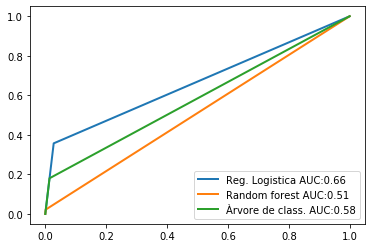

In [78]:
plt.plot(tpr_lr, fpr_lr, linewidth=2,label = "Reg. Logistica"+" AUC:"+str(round(roc_lr,2)))
plt.plot(tpr_fl, fpr_fl, linewidth=2,label = "Random forest"+" AUC:"+str(round(roc_fl,2)))
plt.plot(tpr_ar, fpr_ar, linewidth=2,label = "Àrvore de class."+" AUC:"+str(round(roc_ar,2)))
plt.legend(loc="lower right")

O random forest pode ser considerado um classificador aleatório, dado que a AUC dele é de 0.51  - ou seja, esse classificador não performaria melhor do que se, para cada cliente, a gente decidisse no cara e coroa se é um cliente que seria adquirinte ou não.

Dentre os três, o modelo de regressão logística foi o que perfomou "melhor" com uma AUC de 0.66. 

Vamos testá-lo na amostra de teste. Novamente selecionamos apenas as variáveis necessárias ao modelo e ajustamos.

In [79]:
#removo as variáveis não significativas
X_teste1 = X_teste.drop(['job_student',
                         'job_admin.',
                         'job_retired',
                         'balance_quantile_3 De 227 a 648 euros',
                         'job_management',
                         'job_technician',
                         'balance_quantile_4 De 648 a 1766 euros',
                         'balance_quantile_5 Acima de 1766 euros'  ,
                         'marital_divorced' ,
                         'month_apr'  ,
                         'month_feb',
                         'month_jun'  ,
                         'age_categorizado_5 De 60 a 70 anos'   ,   
                         'age_categorizado_6 Acima de 70 anos' ], axis=1)

Faço aqui a a avaliação da matriz de confusão e da curva ROC para ver se os valores estão próximos da amostra de treino.

In [80]:
avaliacao_confusao(grade_lr,X_teste1, y_teste)

Matriz de confusão
[[8709  265]
 [ 791  408]]
Taxa de precisão:  0.6062 
Taxa de revocação: 0.3403 
Escore F1:  0.4359


0.6553769085113458

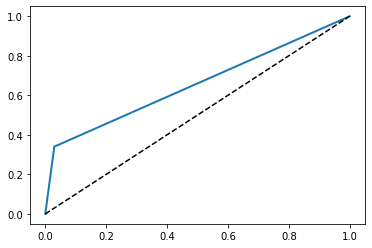

In [81]:
tpr_lr, fpr_lr, roc_lr = avaliacao_ROC(grade_lr,X_teste1,y_teste )
plt.plot(tpr_lr, fpr_lr, linewidth=2,label = "Reg. Logistica"+" AUC:"+str(round(roc_lr,2)))
plt.plot([0, 1],[0, 1], 'k--')
roc_lr

Aparentemente, nada anormal com o ajuste na amostra de teste.

Vamos finalmente gerar a coluna y'(y_hat) de respostas



In [82]:
#removo as variáveis não significativas
explicativas1 = explicativas.drop(['job_student',
                                   'job_admin.',
                                   'job_retired',
                                   'balance_quantile_3 De 227 a 648 euros',
                                   'job_management',
                                   'job_technician',
                                   'balance_quantile_4 De 648 a 1766 euros',
                                   'balance_quantile_5 Acima de 1766 euros'  ,
                                   'marital_divorced' ,
                                   'month_apr'  ,
                                   'month_feb',
                                   'month_jun'  ,
                                   'age_categorizado_5 De 60 a 70 anos'   ,  
                                   'age_categorizado_6 Acima de 70 anos' ], axis=1)

In [83]:
campanhas['y_hat'] = grade_lr.predict(explicativas1)



## Plano de ação sugerido

* No que se refere a como e quando abordar o cliente, é necessário observamos alguns pontos:
 * A duração da ligação tem um fator importante para predizer se o cliente vai se inscrever ou não no produto, possivelmente, por conta de que o cliente tenha interesse no mesmo. 
 * Reabordagens podem ser uma estratégia interessante, pois clientes reabordados apresentaram maiores chances de se inscreverem ao produto que não abordados, independente se foi com sucesso ou não. No entanto, é necessário cautela na quantidade de vezes que o cliente seria reabordado, pois clientes que foram abordados mais de três vezes apresentaram menores chances de se inscreverem ao produto. Um numero prudente de vezes que cada cliente poderia ser abordado seria três, pois daria chances para ter pelo menos uma abordagem com sucesso.
 * Aparentemente, clientes tem maiores chances de se inscreverem no começo do mês, usualmente no dia primeiro. Uma campanha efetiva pode ser construída no começo do mês.
 * A abordagem por celular apresentou maior taxa de inscrição que os demais canais. Dado a versatilidade do canal, e nem sempre o cliente teria a disponibilidade e/ou imagina que a ligação ofertando o produto seja golpe, pode-se considerar algumas outras estratégias de abordagens usando o canal (por exemplo, SMS, Whatsapp).

* No que diz respeito ao público abordável, conseguimos *grosso modo* traçar algumas características propensa a se inscrever. 
 * São clientes ou jovens (abaixo de 30 anos) ou clientes idosos (acima de 70 anos);
 * São estudantes, aposentados ou técnicos;
 * Não estão casados;
 * Não possuem nenhum tipo de empréstimo.
 
* Usamos modelos simples para o problema. Podemos melhorar os modelos, usando o XGBoost como uma alternativa, modelos de redes neurais, etc.

